# Signatures and modeling with them

## Computing signatures

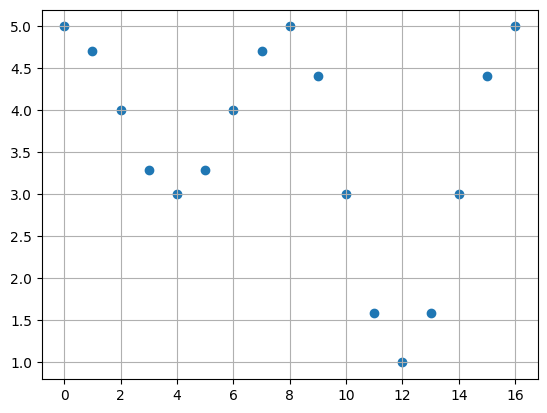

In [2]:
import numpy as np
import matplotlib.pyplot as plt

data = np.array([
    [0.0, 5.0], [1.0, 4.707], [2.0, 4.0], [3.0, 3.292], [4.0, 3.0],
    [5.0, 3.292], [6.0, 4.0], [7.0, 4.707], [8.0, 5], [9.0, 4.414],
    [10.0, 3.0], [11.0, 1.586], [12.0, 1.0], [13.0, 1.586], [14.0, 3.0],
    [15.0, 4.414], [16.0, 5]
])

plt.scatter(data[:, 0], data[:, 1])
plt.grid()

In [3]:
from src.util.signature import signature

depth = 3
sig = signature(data, depth)

np.set_printoptions(precision=5, suppress=True)
for x in range(depth+1):
    print(sig[x], '\n')

1.0 

[16.  0.] 

[[128.     24.002]
 [-24.002   0.   ]] 

[[[ 682.66667  224.008  ]
  [ -63.984     29.0256 ]]

 [[-160.024    -58.05121]
  [  29.0256     0.     ]]] 



### Comparison with a standard package

In [4]:
import esig

esig.stream2sig(data, depth)

array([   1.     ,   16.     ,    0.     ,  128.     ,   24.002  ,
        -24.002  ,    0.     ,  682.66667,  224.008  ,  -63.984  ,
         29.0256 , -160.024  ,  -58.05121,   29.0256 ,    0.     ])

## Reconstructing asset price with Heston model

### The model

The Heston model is
$$
\begin{aligned}
    \mathrm{d} S_t &= \mu S_t \, \mathrm{d} t +  S_t \sqrt{V_t} \, \mathrm{d} W_t^S \\
    \mathrm{d} V_t &= \kappa (\theta - V_t) \, \mathrm{d} t + \sigma \sqrt{V_t} \, \mathrm{d} W_t^V \\
    \mathrm{d} \left[W^S, W^V \right]_t &= \rho \, \mathrm{d} t
\end{aligned}
$$
where $S_t$ is the price, $V_t$ is the variance of the volatility, and $\mu$, $\kappa$, $\theta$, $\sigma$ are constants.
Brownian motions $W^S$ and $W^V$ are correlated wth coefficient $-1 \leq \rho \leq 1$.

#### The goal

Can we create a model using the signature of $X = (t, W^S, W^V)$ that is able to reconstruct the price and volatility data?
This is also called calibration.

### Creating the model

1.  Observe price and volatility data.
2.  Estimate the underlying Brownian motion.
3.  Use linear regression with Lasso regularization to create a model.

We use the same parameters as [Cuchiero, Gazzani, Svaluto-Ferro: Signature-based models: theory and calibration](https://arxiv.org/abs/2207.13136)

In [5]:
rng = np.random.default_rng()

S0 = 1.0
V0 = 0.08
t0 = 0.0
tn = 1.0
n = 1000
mu = 0.001
kappa = 0.5
theta = 0.15
sigma = 0.25
rho = 0.5

params = (S0, V0, t0, tn, n, mu, kappa, theta, sigma, rho)

#### Simulate data with Euler-Maruyama

In [7]:
from src.util.heston import *
from src.util.brownian import estimate_brownian

t, u, w = heston_euler(*params, rng)

w_est = estimate_brownian(w)
brownian_data = np.column_stack((t, w_est))

# can also directly use the Brownian motions used to generate the Heston model
# input_data = np.column_stack((t, w))

#### Compute the signature for each time

In [8]:
samples, channels = brownian_data.shape
depth = 3

# since the signature always starts with 1, ignore it
sig_keys = esig.sigkeys(channels, depth).strip().split(' ')
features = len(sig_keys) - 1

data = np.zeros((samples, features))

for i in range(2, n+2):
    data[i-1, :] = esig.stream2sig(brownian_data[:i, :], depth)[1:]

#### Perform linear regression

In [9]:
import sklearn

# price
s = u[:, 0]

lasso_reg = 1e-5
model = sklearn.linear_model.Lasso(alpha=lasso_reg, max_iter=10000)
model.fit(data, s)

Lasso(alpha=1e-05, max_iter=10000)

### Testing the model

To test the model, we

1.  Generate new data the model has not seen and estimate the Brownian motions.
2.  Feed the data into the model.
3.  Evaluate using mean squared error (as is used in the above paper)

In [20]:
# simulate new data
# t, u, w = heston_euler(*params, rng)
t, u = heston_qe(*params, rng)    # heston model with quadratic exponential scheme

w_est = estimate_brownian(u)
brownian_data = np.column_stack((t, w_est))

# compute the signature
samples, channels = brownian_data.shape
depth = 3
sig_keys = esig.sigkeys(channels, depth).strip().split(' ')
features = len(sig_keys) - 1

data = np.zeros((samples, features))

for j in range(2, n+2):
    data[j-1, :] = esig.stream2sig(brownian_data[:j, :], depth)[1:]

# make prediction using the model
s_real = u[:, 0]
s_predicted = model.predict(data)

# error
sklearn.metrics.mean_squared_error(s_real, s_predicted)

0.0008422389312787434

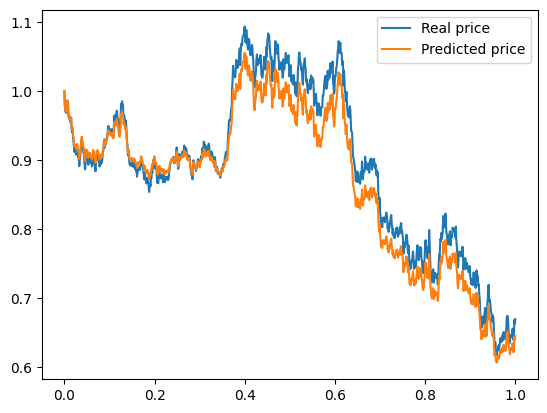

In [21]:
plt.plot(t, s_real, label="Real price")
plt.plot(t, s_predicted, label="Predicted price")
plt.legend()
plt.show()